<a href="https://colab.research.google.com/github/saanvi0204/credit_card_fraud_detection/blob/main/implementing_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up environment

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

RANDOM_SEED = 42
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Autoencoders/Credit card fraud detection/processed_df.csv")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V17,V18,V19,V20,V21,V24,V27,V28,Log_Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.207971,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,5.014760,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,1.305626,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,5.939276,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,4.824306,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,4.262539,0


In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V17,V18,V19,V20,V21,V24,V27,V28,Log_Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,4.473266e-15,-3.660091e-16,-1.227390e-16,3.152188,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,6.056471e-01,4.036325e-01,3.300833e-01,1.656648,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-2.836627e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-3.545861e-01,-7.083953e-02,-5.295979e-02,1.887070,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,4.097606e-02,1.342146e-03,1.124383e-02,3.135494,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,4.395266e-01,9.104512e-02,7.827995e-02,4.358822,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,4.584549e+00,3.161220e+01,3.384781e+01,10.153941,1.000000


In [ ]:
df['Log_Amount'] = StandardScaler().fit_transform(df['Log_Amount'].values.reshape(-1, 1))

## Training autoencoder

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
train_x_normal = train_x[train_y == 0]

In [ ]:
train_x_train, train_x_val = train_test_split(train_x_normal, test_size=0.1, random_state=42)

In [ ]:
train_x.shape[1]

24

In [ ]:
input_dim = train_x.shape[1]
encoding_dim = 16
hidden_dim = 8
optimizer_lr = 1e-3
l2_reg = 1e-4
dropout_rate = 0.1

In [ ]:
input_layer = Input(shape=(input_dim, ))

# Encoder with Dense -> BatchNorm -> Activation -> Dropout
encoder = Dense(encoding_dim)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Activation("relu")(encoder)
encoder = Dropout(dropout_rate)(encoder)

encoder = Dense(hidden_dim)(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation("relu")(encoder)

# Decoder (mirror the encoder structure)
decoder = Dense(hidden_dim)(encoder)
decoder = BatchNormalization()(decoder)
decoder = Activation("relu")(decoder)

decoder = Dense(input_dim)(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation("relu")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
# 1. EarlyStopping to halt training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 2. ModelCheckpoint to save the best model
save_model = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Autoencoders/Credit card fraud detection/best_ae_model1.keras',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

# 3. TensorBoard for logging
log_subdir = "autoencoder_logs"
os.makedirs(log_subdir, exist_ok=True)
tensorboard = TensorBoard(
    log_dir=log_subdir,
    update_freq='batch'
)

# 4. Learning Rate Scheduler to reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6
)

callbacks_list = [early_stop, save_model, tensorboard, lr_scheduler]

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(
    train_x_train, train_x_train,
    shuffle=True,
    epochs=100,
    batch_size=128,
    callbacks=callbacks_list,
    validation_data=(train_x_val, train_x_val),
    verbose=1
).history

Epoch 1/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4370 - loss: 0.1423 - val_accuracy: 0.9771 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 2/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9680 - loss: 0.0091 - val_accuracy: 0.9919 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9910 - loss: 0.0030 - val_accuracy: 0.9927 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9925 - loss: 0.0026 - val_accuracy: 0.9926 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 5/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9924 - loss: 0.0026 - val_accuracy: 0.9926 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9921 - loss: 0.0026
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.

## Evaluating autoencoder

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/Autoencoders/Credit card fraud detection/best_ae_model1.keras')

In [ ]:
val_loss, val_acc = autoencoder.evaluate(train_x_val, train_x_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9925 - loss: 0.0026
Validation Loss: 0.002562478417530656, Validation Accuracy: 0.9925701022148132


In [ ]:
test_loss, test_acc = autoencoder.evaluate(test_x, test_x)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9913 - loss: 0.0026
Test Loss: 0.002620803425088525, Test Accuracy: 0.9912397861480713


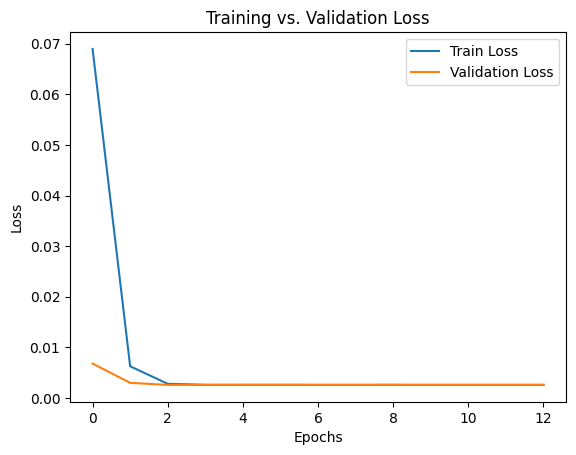

In [ ]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

## t-SNE plot

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.ticker as ticker

RATIO_TO_FRAUD = 15
RANDOM_SEED = 42

In [ ]:
encoder_layer_index = len(autoencoder.layers) // 2
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[encoder_layer_index].output)

fraud = df[df.Class == 1]
legit = df[df.Class == 0]
legit_undersampled = legit.sample(min(int(len(fraud) * RATIO_TO_FRAUD), len(legit)), random_state=RANDOM_SEED)

visualisation_final = pd.concat([fraud, legit_undersampled])

features_final = visualisation_final.drop('Class', axis=1).values
labels_final = visualisation_final.Class.values

scaler = MinMaxScaler()
features_final_scaled = scaler.fit_transform(features_final)

encoded_features = encoder.predict(features_final_scaled)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d.')

    features_embedded = TSNE(n_components=dimensions,
                             random_state=RANDOM_SEED).fit_transform(features)

    fig, ax = plt.subplots(figsize=(8, 8))
    if dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')

    fraud_points = features_embedded[labels == 1]
    legit_points = features_embedded[labels == 0]

    if dimensions == 2:
        ax.scatter(fraud_points[:, 0], fraud_points[:, 1], marker='o', color='r', s=2, alpha=0.7, label='Fraud')
        ax.scatter(legit_points[:, 0], legit_points[:, 1], marker='o', color='g', s=2, alpha=0.3, label='Legitimate')

        ax.set_xlim([-100, 100])
        ax.set_ylim([-100, 100])
    else:
        ax.scatter(fraud_points[:, 0], fraud_points[:, 1], fraud_points[:, 2], marker='o', color='r', s=2, alpha=0.7, label='Fraud')
        ax.scatter(legit_points[:, 0], legit_points[:, 1], legit_points[:, 2], marker='o', color='g', s=2, alpha=0.3, label='Legitimate')

    formatter = ticker.FuncFormatter(lambda x, pos: f'{x * 0.001:.2f}')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show()

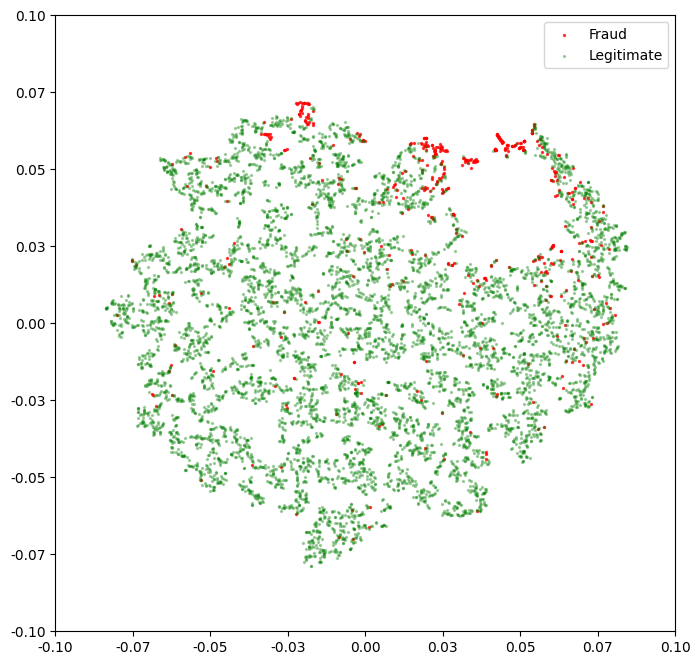

In [ ]:
tsne_scatter(encoded_features, labels_final, dimensions=2, save_as='tsne_latent_2d.png')